<a href="https://colab.research.google.com/github/jpcastrellont/Hello-World/blob/master/Bitcarrier_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import requests
import json
import numpy as np
import pandas as pd
from unicodedata import normalize
from sqlalchemy import create_engine
import os
import psycopg2
import io
import matplotlib.pyplot as plt
import warnings
import folium
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [6]:
#Conexión con la base de datos
host = 'team73test.c4xr0dadx0gz.us-east-2.rds.amazonaws.com'
port = 5432
user = 'postgres'
password = 'ds4a_t73'
database = 'postgres'

In [7]:
connDB = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database}')
conn = connDB.raw_connection()
cur = conn.cursor()

In [8]:
%load_ext sql
%sql postgresql://{user}:{password}@{host}/{database}

'Connected: postgres@postgres'

In [ ]:
#Loading Bitcarrier
df = pd.read_sql(''' SELECT * FROM carguebogota.bitcarr ''', conn)

In [ ]:
#Data cleaning
df['name_from'] = df['name_from'].replace('KR50,CL13', 'CL13')
df['name_from'] = df['name_from'].replace('CL13,KR50', 'CL13')

df['name_to'] = df['name_to'].replace('CL5A;KR47', 'KR50;KR47')
df['name_to'] = df['name_to'].replace('CL17;KR56', 'KR50;KR56')
df['name_to'] = df['name_to'].replace('KR62;CL5A', 'KR62;KR50')

In [ ]:
#Defining direction
West_East = ['KR97;KR90', 'KR123;KR106', 'CL17;KR129', 'KR106;KR97','KR128;KR123','KR128;AV.CARACAS','KR27;KR22','KR22;AV.CARACAS',
              'KR39;KR33','KR33;KR27','KR47;KR39','KR56;KR47','KR65;KR56','KR68;KR65','KR68D;KR68','KR90;KR68D','KR62;KR50','KR50;KR47','KR119;AV.CARACAS',
              'KR24;CARACAS', 'KR69H;KR58','KR76;KR71','KR81;KR76','KR89A;KR81', 'KR58;KR24', 'KR112A;KR102','KR119;KR112A','KR71;KR69H;',
              'KR102;KR96','KR96;KR89A','KR90;KR68','KR128;KR106']
East_West = ['KR90;KR97','KR97;KR106','KR106;KR123','KR129;CL17','KR123;KR128','AV.CARACAS;KR128','KR50;KR56','KR22;KR27','AV.CARACAS;KR22',
              'KR33;KR39','KR39;KR47','KR27;KR33','KR47;KR56','KR56;KR65','KR65;KR68','KR68;KR68D','KR68D;KR90','AV.CARACAS;KR119','CARACAS;KR24',
              'KR69H;KR71','KR76;KR81','KR81;KR89A','KR24;KR58','KR58;KR69H','KR112A;KR119','KR71;KR76' ,'KR102;KR112A''KR96;KR102','KR89A;KR96',
              'KR68;KR90','KR106;KR128']
df['orientation'] = 'west_east'
df['orientation'] = df['orientation'].where(df['name_to'].isin(West_East), 'east_west')

In [ ]:
#Defining coordenates 
coordenadas1 = {'KR97;KR90': ([-74.14853144099999, 4.666731241846797],
  [-74.13958359200001, 4.66322384184687]),
 'KR90;KR97': ([-74.13959365, 4.663407966846895],
  [-74.14852004199997, 4.6669153668467676]),
 'KR123;KR106': ([-74.15966864400002, 4.686716340846148],
  [-74.152940322, 4.673972885846544]),

 #'CL17;KR129': ([[-74.13959365, 4.663407966846895],
 #  [-74.16347621800003, 4.690046288846024]]),
 
 'KR106;KR97': ([-74.15295172200001, 4.67388500184656],
  [-74.14872456, 4.666804757846783]),
 'KR97;KR106': ([-74.148692374, 4.666987879846787],
  [-74.15278006, 4.6739705468465464]),
 'KR106;KR123': ([-74.15278006, 4.674109557846537],
  [-74.159474854, 4.686962612846106]),

 #'KR129;CL17': ([[-74.16369079499998, 4.689864509846029],
 # [-74.13958359200001, 4.66322384184687]]),

 'KR128;KR123': ([-74.16369079499998, 4.689864509846029],
  [-74.15974258300002, 4.686870486846144]),
 'KR123;KR128': ([-74.15954946400001, 4.6870308808461125],
  [-74.16347621800003, 4.690046288846024]),

# 'AV.CARACAS;KR128': ([[-74.07990931400002, 4.603861481848834],
#   [-74.16347621800003, 4.690046288846024]]),
# 'KR128;AV.CARACAS': ([[-74.16369079499998, 4.689864509846029],
#   [-74.079995145, 4.603668985848824]]),
# 'CL17;KR56': ([-74.10533665600002, 4.629727653847998],
#  [-74.11004661499999, 4.630438792847955]),

 'KR27;KR22': ([-74.089361419, 4.6118393248485665],
  [-74.08700107499999, 4.609711195848607]),
 'KR22;KR27': ([-74.08688305800001, 4.610010631848636],
  [-74.08914684199999, 4.612010430848545]),
 'AV.CARACAS;KR22': ([-74.07990931400002, 4.603861481848834],
  [-74.08670066799999, 4.609860913848646]),
 'KR22;AV.CARACAS': ([-74.08690451500001, 4.609721889848635],
  [-74.079995145, 4.603668985848824]),
 'KR33;KR27': ([-74.09449516699999, 4.616376281848395],
  [-74.08945261399998, 4.611906162848576]),
 'KR33;KR39': ([-74.09424840399998, 4.616611550848413],
  [-74.09915148200002, 4.620974700848282]),
 'KR39;KR33': ([-74.09959136399999, 4.620857066848242],
  [-74.09456490399998, 4.616403016848387]),
 'KR39;KR47': ([-74.09923194800001, 4.621022822848241],
  [-74.104105522, 4.625377924848134]),
 'KR47;KR39': ([-74.10428254800001, 4.625107904848125],
  [-74.09968524099997, 4.620937271848254]),
 'KR27;KR33': ([-74.08931313900001, 4.612173515848538],
  [-74.094216217, 4.616568774848427]),
 'KR56;KR47': ([-74.11038725499998, 4.630064508847984],
  [-74.104368378, 4.62517206784811]),
 'KR47;KR56': ([-74.104135026, 4.625396639848137],
  [-74.11012976299997, 4.630337201847981]),
 'KR56;KR65': ([-74.11014652699998, 4.630466195847943],
  [-74.114566808, 4.634631425847818]),
 'KR65;KR56': ([-74.11476730300001, 4.634342025847845],
  [-74.11041139500003, 4.630289079847973]),
 'KR65;KR68': ([-74.11475657400001, 4.634737694847827],
  [-74.11796449600001, 4.637304190847732]),
 'KR68;KR65': ([-74.118191142, 4.637183886847728],
  [-74.11501004299998, 4.63459065584782]),
 'KR68;KR68D': ([-74.118313183, 4.637643716847724],
  [-74.12185369899998, 4.640146039847636]),
 'KR68D;KR68': ([-74.12215410599998, 4.639846616847637],
  [-74.11861359, 4.637344292847741]),
 'KR68D;KR90': ([-74.12217556399997, 4.640381300847623],
  [-74.13942753200001, 4.663313498846907]),
 'KR90;KR68D': ([-74.139486541, 4.663121018846908],
  [-74.12230967400001, 4.640007022847652]),

# 'KR62;CL5A': ([-74.11781429199999, 4.6281529858480095],
#  [-74.11165593999999, 4.620763494848274]),
# 'CL5A;KR47': ([-74.11148427900002, 4.620592390848272],
#  [-74.10448907799997, 4.625212169848124]),
# 'AV.CARACAS;KR119': ([[-74.06101013400001, 4.666237280846801],
#   [-74.12464319600002, 4.726235508844826]]),
# 'KR119;AV.CARACAS': ([[-74.12494360400001, 4.7259788918448455],
#   [-74.06105874899998, 4.665849147846814]]),

 'CARACAS;KR24': ([-74.06101013400001, 4.666237280846801],
  [-74.06341121399998, 4.669238909846679]),
 'KR24;CARACAS': ([-74.06340534700001, 4.668773753846683],
  [-74.06105874899998, 4.665849147846814]),
 'KR69H;KR58': ([-74.08261298100001, 4.688132254846106],
  [-74.07448052299998, 4.678401610846421]),
 'KR69H;KR71': ([-74.08237426400001, 4.6885385868460485],
  [-74.087202241, 4.694376904845891]),
 'KR76;KR71': ([-74.09331767700002, 4.697349509845761],
  [-74.087717225, 4.694291361845883]),
 'KR76;KR81': ([-74.09317015599999, 4.697841377845783],
  [-74.09722565599998, 4.700300715845692]),
 'KR81;KR76': ([-74.09735440200001, 4.699915776845694],
  [-74.09355639400002, 4.697477822845764]),
 'KR81;KR89A': ([-74.09729002900002, 4.700364872845687],
  [-74.103298177, 4.70438533584552]),
 'KR89A;KR81': ([-74.103577127, 4.704064554845563],
  [-74.09754752100002, 4.700001318845711]),
 'KR24;KR58': ([-74.063365449, 4.669312425846669],
  [-74.07400845500001, 4.678487155846406]),
 'KR58;KR24': ([-74.07428740400002, 4.678230521846378],
  [-74.06358002600001, 4.668948855846692]),
 'KR58;KR69H': ([-74.07422303099997, 4.678658244846394],
  [-74.082398404, 4.688431657846084]),
 'KR119;KR112A': ([-74.12494360400001, 4.7259788918448455],
  [-74.11968647399999, 4.719392366845072]),
 'KR102;KR112A': ([-74.11365150400002, 4.711634943845336],
  [-74.11929487200001, 4.719419098845057]),
 'KR112A;KR102': ([-74.11955236400001, 4.719280096845088],
  [-74.11384462299998, 4.7113890138453405]),
 'KR112A;KR119': ([-74.11932705800001, 4.719568792845059],
  [-74.12464319600002, 4.726235508844826]),
 'KR71;KR69H;': ([-74.08748119, 4.694077504845876],
  [-74.08278195999998, 4.688367499846097]),
 'KR71;KR76': ([-74.08737390200002, 4.694633532845872],
  [-74.092845608, 4.69767029284575]),
 'KR96;KR102': ([-74.10937069800002, 4.707550365845468],
  [-74.11338328300002, 4.711421091845338]),
 'KR102;KR96': ([-74.113748063, 4.711185854845323],
  [-74.10967110600001, 4.707186815845446]),
 'KR89A;KR96': ([-74.10340546499998, 4.704492262845564],
  [-74.10924195199999, 4.707400668845434]),
 'KR96;KR89A': ([-74.10947798699999, 4.707079888845457],
  [-74.10368441499998, 4.704064554845563]),
 'KR90;KR68': ([-74.139486541, 4.663121018846908],
  [-74.12230967400001, 4.640007022847652]),
 'KR68;KR90': ([-74.12217556399997, 4.640381300847623],
  [-74.13942753200001, 4.663313498846907])}


In [ ]:
#Add coordinates as new column to db
coordenadas = {}
for i in coordenadas1.keys():
  np.flip(coordenadas1[i][0])
  coordenadas.update( {i: (np.flip(coordenadas1[i][0]) , np.flip(coordenadas1[i][1]))})
df['coordinates']= df['name_to'].map(coordenadas)

In [ ]:
#Split df into CL13 and CL80
df_CL13 = df[df['name_from'].isin(['DIAG16', 'CL17', 'CL13'])]
df_CL80 = df[df['name_from'] == 'CL80']

#**CALLE 13**


### *Average speed per weekday*

In [ ]:
df_CL13_ew = df_CL13[df_CL13['orientation'] == 'east_west']
df_CL13_we = df_CL13[df_CL13['orientation'] == 'west_east']

avg_velocity_per_weekday_CL13 = df_CL13[['month','average_speed','weekday']].groupby(['month','weekday']).mean().reset_index()
avg_velocity_per_weekday_CL13 = df_CL13[['month','average_speed','weekday']].groupby(['month','weekday']).mean().reset_index()

fig = px.bar(avg_velocity_per_weekday_CL13, x="weekday", y="average_speed", animation_frame="month", animation_group="weekday",color="average_speed",color_continuous_scale=px.colors.sequential.RdBu)
fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

### *Average speed per hour of the day*

In [ ]:
avg_velocity_per_hour_CL13 = df_CL13[['month','average_speed','hour']].groupby(['month','hour']).mean().reset_index()
fig = px.bar(avg_velocity_per_hour_CL13, x="hour", y="average_speed", animation_frame="month", animation_group="hour",color="average_speed",color_continuous_scale=px.colors.sequential.RdBu)
fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

### *Average speed per month for 2018 and 2019*

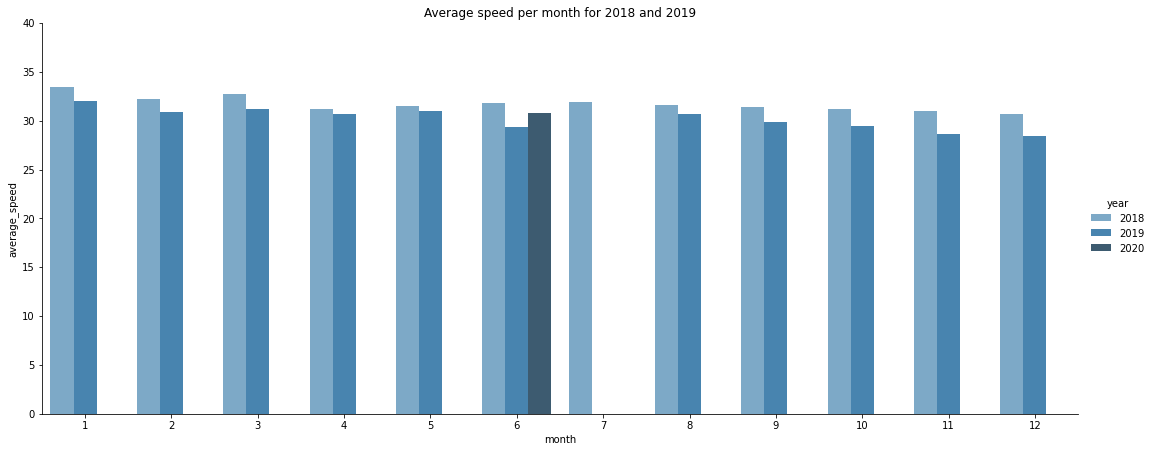

In [ ]:
avg_per_year_13 = df_CL13[['average_speed','year','month']].groupby(['month','year']).mean().reset_index()#.plot.bar() 
g = sns.catplot(x="month", y="average_speed", hue="year", data=avg_per_year_13,kind = 'bar',palette="Blues_d",height=6, aspect=2.5)
g.set(title = 'Average speed per month for 2018 and 2019',ylim=(0, 40))

### *Average speed per hour for orientation of the road*

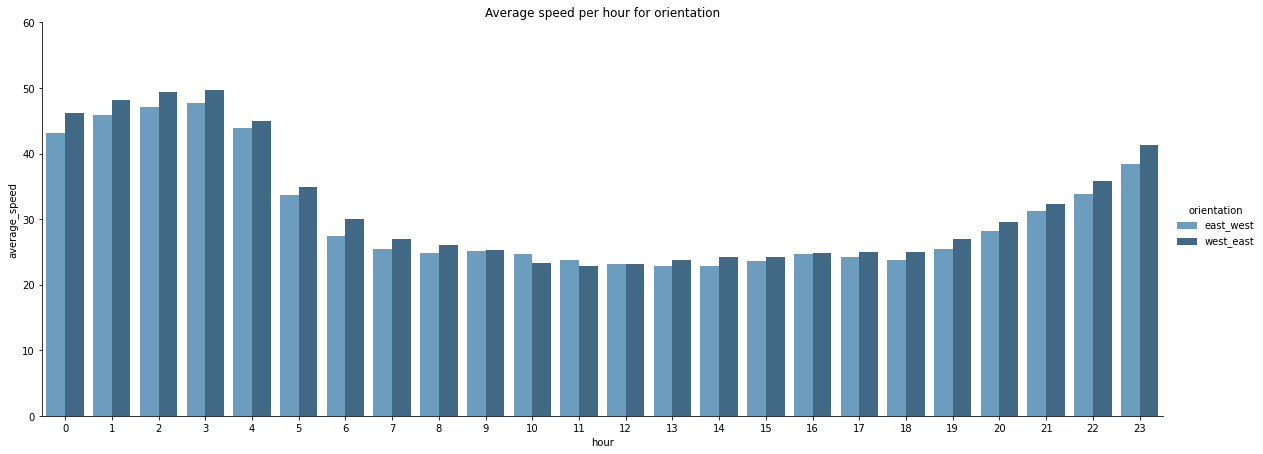

In [ ]:
avg_per_orientation_13 = df_CL13[['orientation','average_speed','hour']].groupby(['orientation','hour']).mean().reset_index()
g = sns.catplot(x="hour", y="average_speed", hue="orientation", data=avg_per_orientation_13,kind = 'bar',palette="Blues_d",height=6, aspect=2.7)
g.set(title = 'Average speed per hour for orientation',ylim=(0, 60))

In [ ]:
avg_speed_corridor_CL13_ew = df_CL13_ew[['name_to','average_speed']].groupby(['name_to']).mean().sort_values('average_speed',ascending = False).reset_index()
avg_speed_corridor_CL13_ew['coordinates']= avg_speed_corridor_CL13_ew['name_to'].map(coordenadas)
avg_speed_corridor_CL13_ew = avg_speed_corridor_CL13_ew.dropna()
color_speed = ['#300000','#300000','#600000','#600000','#900000','#900000','#c00000','#c00000','#ef0000','#ef0000','#ff9090','#ff9090','#ffcfcf','#ffcfcf','#ffefef']
avg_speed_corridor_CL13_ew['color_speed'] = color_speed

In [ ]:
avg_speed_corridor_CL13_we = df_CL13_we[['name_to','average_speed']].groupby(['name_to']).mean().sort_values('average_speed',ascending = False).reset_index()
avg_speed_corridor_CL13_we['coordinates']= avg_speed_corridor_CL13_we['name_to'].map(coordenadas)
avg_speed_corridor_CL13_we = avg_speed_corridor_CL13_we.dropna()
avg_speed_corridor_CL13_we['color_speed'] = color_speed

### *Map of corridor East to West. Color defined by average velocity*

In [ ]:
#Map Calle 13 East-West
f = folium.Figure(width=600, height=500)
mapCL13_ew = folium.Map(location=[4.648098, -74.131369], zoom_start=13.2)
list_coord = avg_speed_corridor_CL13_ew['coordinates'].tolist()
list_color = avg_speed_corridor_CL13_ew['color_speed'].tolist()

for i in range(len(list_coord)):
  folium.PolyLine(list_coord[i], weight=7, opacity=1, color = list_color[i]).add_to(mapCL13_ew)
#folium.TileLayer('cartodbpositron').add_to(mapCL13_we)
f.add_child(mapCL13_ew)

### *Map of corridor West to East. Color defined by average velocity*

In [ ]:
#Map Calle 13 West-East

f = folium.Figure(width=600, height=500)
mapCL13_we = folium.Map(location=[4.648098, -74.131369], zoom_start=13.2)
list_coord = avg_speed_corridor_CL13_we['coordinates'].tolist()
list_color = avg_speed_corridor_CL13_we['color_speed'].tolist()

for i in range(len(list_coord)):
  folium.PolyLine(list_coord[i], weight=7, opacity=1, color = list_color[i]).add_to(mapCL13_we)
folium.TileLayer('cartodbpositron').add_to(mapCL13_we)
f.add_child(mapCL13_we)

# **CALLE 80**

### *Average speed per weekday*

In [ ]:
df_CL80_ew = df_CL80[df_CL80['orientation'] == 'east_west']
df_CL80_we = df_CL80[df_CL80['orientation'] == 'west_east']

avg_velocity_per_weekday_CL80 = df_CL80[['month','average_speed','weekday']].groupby(['month','weekday']).mean().reset_index()

fig = px.bar(avg_velocity_per_weekday_CL80, x="weekday", y="average_speed", animation_frame="month", animation_group="weekday",color="average_speed",color_continuous_scale=px.colors.sequential.RdBu)
fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

### *Average speed per hour of the day*

In [ ]:
avg_velocity_per_hour_CL80 = df_CL80[['month','average_speed','hour']].groupby(['month','hour']).mean().reset_index()
fig = px.bar(avg_velocity_per_hour_CL80, x="hour", y="average_speed", animation_frame="month", animation_group="hour",color="average_speed",color_continuous_scale=px.colors.sequential.RdBu)
fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

### *Average speed per month for 2018 and 2019*

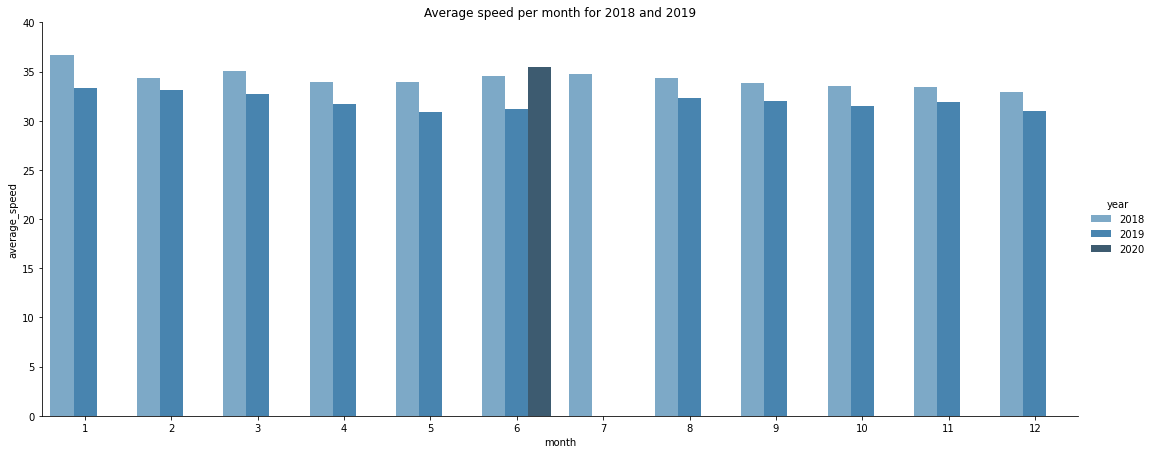

In [ ]:
avg_per_year_80 = df_CL80[['average_speed','year','month']].groupby(['month','year']).mean().reset_index()#.plot.bar() 
g = sns.catplot(x="month", y="average_speed", hue="year", data=avg_per_year_80,kind = 'bar',palette="Blues_d",height=6, aspect=2.5)
g.set(title = 'Average speed per month for 2018 and 2019',ylim=(0, 40))


### *Average speed per hour for orientation of the road*

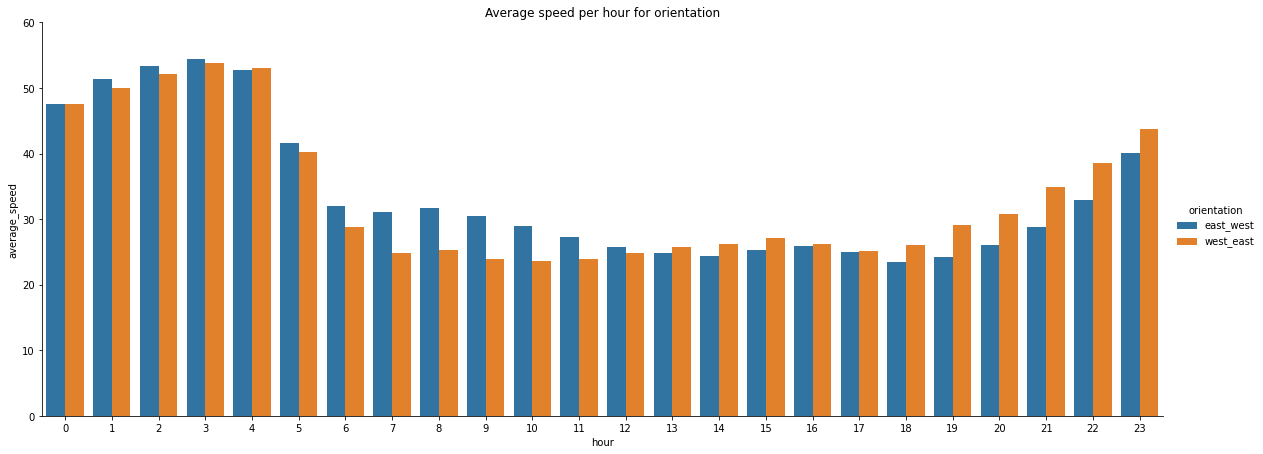

In [ ]:
avg_per_orientation_80 = df_CL80[['orientation','average_speed','hour']].groupby(['orientation','hour']).mean().reset_index()
g = sns.catplot(x="hour", y="average_speed", hue="orientation", data=avg_per_orientation_80,kind = 'bar',height=6, aspect=2.7)
g.set(title = 'Average speed per hour for orientation',ylim=(0, 60))

In [ ]:
df_CL80_ew = df_CL80[df_CL80['orientation'] == 'east_west']
df_CL80_we = df_CL80[df_CL80['orientation'] == 'west_east']

In [ ]:
avg_speed_corridor_CL80_ew = df_CL80_ew[['name_to','average_speed']].groupby(['name_to']).mean().sort_values('average_speed',ascending = False).reset_index()
avg_speed_corridor_CL80_ew['coordinates']= avg_speed_corridor_CL80_ew['name_to'].map(coordenadas)
avg_speed_corridor_CL80_ew = avg_speed_corridor_CL80_ew.dropna()
color_speed = ['#300000','#600000','#900000','#c00000','#ef0000','#ff5050','#ff9090','#ffa0a0','#ffb0b0','#ffcfcf','#ffefef']
avg_speed_corridor_CL80_ew['color_speed'] = color_speed

In [ ]:
avg_speed_corridor_CL80_we = df_CL80_we[['name_to','average_speed']].groupby(['name_to']).mean().sort_values('average_speed',ascending = False).reset_index()
avg_speed_corridor_CL80_we['coordinates']= avg_speed_corridor_CL80_we['name_to'].map(coordenadas)
avg_speed_corridor_CL80_we = avg_speed_corridor_CL80_we.dropna()
avg_speed_corridor_CL80_we['color_speed'] = color_speed

### *Map of corridor East to West. Color defined by average velocity*

In [ ]:
#Map Calle 80 East-West
f = folium.Figure(width=600, height=500)
mapCL80_ew = folium.Map(location=[4.703411, -74.101624], zoom_start=13.2)
list_coord = avg_speed_corridor_CL80_ew['coordinates'].tolist()
list_color = avg_speed_corridor_CL80_ew['color_speed'].tolist()

for i in range(len(list_coord)):
  folium.PolyLine(list_coord[i], weight=7, opacity=1, color = list_color[i]).add_to(mapCL80_ew)
folium.TileLayer('cartodbpositron').add_to(mapCL80_ew)
f.add_child(mapCL80_ew)

### *Map of corridor West to East. Color defined by average velocity*

In [ ]:
#Map Calle 80 West-East
f = folium.Figure(width=600, height=500)
mapCL80_we = folium.Map(location=[4.703411, -74.101624], zoom_start=13.2)
list_coord = avg_speed_corridor_CL80_we['coordinates'].tolist()
list_color = avg_speed_corridor_CL80_we['color_speed'].tolist()

for i in range(len(list_coord)):
  folium.PolyLine(list_coord[i], weight=7, opacity=1, color = list_color[i]).add_to(mapCL80_we)
folium.TileLayer('cartodbpositron').add_to(mapCL80_ew)
f.add_child(mapCL80_we)

# **R N D C**

In [9]:
df_rndc = pd.read_sql(''' SELECT * FROM carguebogota.rndc ''', conn)

In [10]:
df_rndc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2575191 entries, 0 to 2575190
Data columns (total 17 columns):
 #   Column          Dtype  
---  ------          -----  
 0   weekday         object 
 1   year            int64  
 2   month           int64  
 3   date            object 
 4   hour            object 
 5   operation_code  bool   
 6   city_cod        int64  
 7   city            object 
 8   paid_vale       float64
 9   a_remittances   int64  
 10  cod_product     object 
 11  product         object 
 12  plaque          int64  
 13  setting         object 
 14  corridor        object 
 15  driver          float64
 16  corridor_2      object 
dtypes: bool(1), float64(2), int64(5), object(9)
memory usage: 316.8+ MB


In [ ]:
df_rndc.head()

,weekday,year,month,date,hour,operation_code,city_cod,city,paid_vale,a_remittances,cod_product,product,plaque,setting,corridor,driver,corridor_2
0,Martes,2019,9,2019-09-10,15:45:00,False,25754000,SOACHA CUNDINAMARCA,259699.0,1,2520,SAL; AZUFRE; TIERRAS Y PIEDRAS; YESOS; CALES Y...,212666,2,AUTO SUR,129694.0,NA
1,Miercoles,2019,9,2019-09-11,12:00:00,False,25754000,SOACHA CUNDINAMARCA,27609.0,2,2520,SAL; AZUFRE; TIERRAS Y PIEDRAS; YESOS; CALES Y...,212666,2,AUTO SUR,129694.0,NA
2,Martes,2019,4,2019-04-30,17:00:00,True,50001000,VILLAVICENCIO META,610.0,1,208,CARNES Y DESPOJOS COMESTIBLES LAS DEMAS CARNES...,41449,2,VIA AL LLANO,177598.0,AUTO NORTE
3,Sabado,2019,9,2019-09-14,14:45:00,False,25754000,SOACHA CUNDINAMARCA,31609.0,1,2520,SAL; AZUFRE; TIERRAS Y PIEDRAS; YESOS; CALES Y...,212666,2,AUTO SUR,129694.0,NA
4,Lunes,2019,9,2019-09-16,19:00:00,False,25754000,SOACHA CUNDINAMARCA,299699.0,2,2520,SAL; AZUFRE; TIERRAS Y PIEDRAS; YESOS; CALES Y...,212666,2,AUTO SUR,129694.0,NA


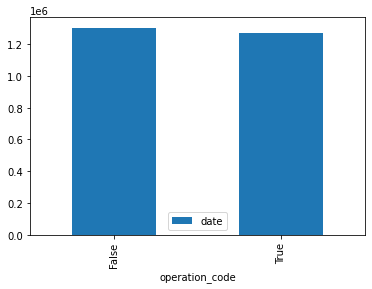

In [ ]:
#Operation code. False: Llegando o descargue en Bogotá
#Operation code. True: Saliendo o cargue en Bogotá
df_rndc[['operation_code','date']].groupby('operation_code').count().plot.bar()

In [ ]:
df_rndc['city'].unique().shape

(1712,)

In [ ]:
df_rndc[['weekday','city']].groupby('city').count().sort_values('weekday',ascending = False).head(30)

,weekday
city,
FUNZA CUNDINAMARCA,256979
CARTAGENA BOLIVAR,155853
MEDELLIN ANTIOQUIA,148437
CALI VALLE DEL CAUCA,145704
BUENAVENTURA VALLE DEL CAUCA,142725
TOCANCIPA CUNDINAMARCA,97726
BARRANQUILLA ATLANTICO,95883
COTA CUNDINAMARCA,92458
BUCARAMANGA SANTANDER,78891


In [ ]:
df_rndc[['year','setting']].groupby('setting').count().sort_values('year',ascending = False) 

,year
setting,
2,1587637
3S3,385481
3S2,192632
2S2,165241
CA,133277
3,71170
2S3,33807
4,3051
3S4,918


In [11]:
df_rndc[['year','product']].groupby('product').count().sort_values('year',ascending = False)

,year
product,
VARIOS PRODUCTOS VARIOS,566336
OTROS MISCELANEOS CONTENIDOS EN PAQUETES ( PAQUETEO ),240511
MADERA; CARBÓN VEGETAL Y MANUFACTURAS DE MADERA; CAJONES; CAJAS; JAULAS; TAMBORES Y ENVASES SIMILARES; DE MADERA; CARRETES,180712
VARIOS CONTENEDOR VACIO,60023
VEHÍCULOS AUTOMÓVILES; TRACTORES; CICLOS Y DEMÁS VEHÍCULOS TERRESTRES; SUS COCHES DE TURISMO Y DEMAS VEHICULOS AUTOMOVILES PROYECTADOS PRINCIPALMENTE PAR,44074
...,...
SUSTANCIAS COMBURENTES Y PERÓXIDOS ORGÁNICOS 3215 - 5.1 - PERSULFATOS INORGÁNICOS; N.E.P.,1
SÓLIDOS INFLAMABLES; SUSTANCIAS QUE PUEDEN EXPERIMENTAR COMBUSTIÓN ESPONTÁNEA; S 1295 - 4.3 - TRICLOROSILANO,1
SÓLIDOS INFLAMABLES; SUSTANCIAS QUE PUEDEN EXPERIMENTAR COMBUSTIÓN ESPONTÁNEA; S 1331 - 4.1 - FÓSFOROS DISTINTOS DE LOS DE SEGURIDAD,1


In [14]:
df_rndc['product'].unique()[-20:-10]

array(['SÓLIDOS INFLAMABLES; SUSTANCIAS QUE PUEDEN EXPERIMENTAR COMBUSTIÓN ESPONTÁNEA; S 1332 - 4.1 - METALDEHIDO',
       'SÓLIDOS INFLAMABLES; SUSTANCIAS QUE PUEDEN EXPERIMENTAR COMBUSTIÓN ESPONTÁNEA; S 2793 - 4.2 - VIRUTAS; TORNEADURAS o RASPADURAS DE METALES FERROSOS en una forma',
       'LOS DEMÁS METALES COMUNES; <<CERMETS>>; MANUFACTURAS DE ESTAS MANGANESO YSUS MANUFACTURAS;  INCLUIDOS LOS DESPERDICIOS Y DESECHOS',
       'RELOJERÍA; PEQUE?OS MECANISMOS DE RELOJERIA COMPLETOS Y MONTADOS',
       'MINERALES; ESCORIAS Y CENIZAS; MINERALES DE PLOMO Y SUS CONCENTRADOS',
       'SUSTANCIAS CORROSIVAS 2079 - 8 - DIETILENTRIAMINA',
       'SÓLIDOS INFLAMABLES; SUSTANCIAS QUE PUEDEN EXPERIMENTAR COMBUSTIÓN ESPONTÁNEA; S 1384 - 4.2 - DITIONITO SÓDICO (HIDROSULFITO SÓDICO)',
       'SÓLIDOS INFLAMABLES; SUSTANCIAS QUE PUEDEN EXPERIMENTAR COMBUSTIÓN ESPONTÁNEA; S 1390 - 4.3 - AMIDAS DE METALES ALCALINOS',
       'SUSTANCIAS COMBURENTES Y PERÓXIDOS ORGÁNICOS 3375 - 5.1 - EMULSIÓN DE NITRAT

In [ ]:
df_rndc['product'].unique()[10:20]

array(['MATERIAS PLÁSTICAS Y MANUFACTURAS DE ESTAS MATERIAS; POLIACETALES;  LOS DEMAS POLIETERES Y RESINAS EPOXI;  EN FORMAS PRIMARIAS; POL',
       'MATERIAS PLÁSTICAS Y MANUFACTURAS DE ESTAS MATERIAS; RESINAS AMINICAS;  RESINAS FENOLICAS Y POLIURETANOS;  EN FORMAS PRIMARIAS',
       'MANUFACTURAS DIVERSAS DE METALES COMUNES; GUARNICIONES;  HERRAJES Y ARTICULOS SIMILARES DE METALCOMUN;  PARA MUEBLES;  P',
       'SAL; AZUFRE; TIERRAS Y PIEDRAS; YESOS; CALES Y CEMENTOS; CEMENTOS HIDRAULICOS (INCLUIDOS LOS CEMENTOS SIN PULVERIZAR O CLINKER);  AUNQU',
       'PRODUCTOS DIVERSOS DE LAS INDUSTRIAS QUÍMICAS; INSECTICIDAS;  RATICIDAS;  FUNGICIDAS;  HERBICIDAS;  INHIBIDORES DE GERMINACIO',
       'MADERA; CARBÓN VEGETAL Y MANUFACTURAS DE MADERA; MADERA EN BRUTO;  INCLUSO DESCORTEZADA;  DESALBURADA O ESCUADRADA',
       'PRODUCTOS EDITORIALES; DE LA PRENSA O DE OTRAS INDUSTRIAS GRÁFICAS; TEXTOS DIARIOS Y PUBLICACIONES PERIODICAS;  IMPRESOS;  INCLUSO ILUSTRADOS O CON PUBLI',
       'MANUFACTURA

In [ ]:
# Construccion

In [ ]:
#Bebidas
'LECHE Y PRODUCTOS LÁCTEOS; HUEVOS DE AVE; MIEL NATURAL; PRODUCTOS SUERO DE MANTEQUILLA (DE MANTECA);  LECHE Y NATA (CREMA) CUAJADAS; YOGUR; KEFI',
       

In [ ]:
# Papel y carton
'PAPEL Y CARTÓN; MANUFACTURAS DE PASTA DE CELULOSA; DE PAPEL O DE CARTÓN; PAPEL Y CARTON KRAFT;  SIN ESTUCAR NI RECUBRIR;  EN BOBINAS O EN HOJAS;  EXCEP',
'MADERA; CARBÓN VEGETAL Y MANUFACTURAS DE MADERA; CAJONES;  CAJAS;  JAULAS;  TAMBORES Y ENVASES SIMILARES;  DE MADERA; CARRETES',


In [ ]:
# Combustibles
'LÍQUIDOS INFLAMABLES 1203 - 3 - COMBUSTIBLE PARA MOTORES o GASOLINA',
       

In [ ]:
# Alimentos
'SAL; AZUFRE; TIERRAS Y PIEDRAS; YESOS; CALES Y CEMENTOS; YESO NATURAL; ANHIDRITA; YESOS CALCINADOS;  INCLUSO COLOREADOS O CON PEQUE?AS',             
'CARNES Y DESPOJOS COMESTIBLES LAS DEMAS CARNES Y DESPOJOS COMESTIBLES; FRESCOS; REFRIGERADOS O CONGELADOS',
'CARNES Y DESPOJOS COMESTIBLES CARNE Y DESPOJOS COMESTIBLES; SALADOS O EN SALMUERA; SECOS O AHUMADOS;  HARIN',
'SAL; AZUFRE; TIERRAS Y PIEDRAS; YESOS; CALES Y CEMENTOS; YESO NATURAL; ANHIDRITA; YESOS CALCINADOS;  INCLUSO COLOREADOS O CON PEQUE?AS',
'CARNES Y DESPOJOS COMESTIBLES LAS DEMAS CARNES Y DESPOJOS COMESTIBLES; FRESCOS; REFRIGERADOS O CONGELADOS', 
'SAL; AZUFRE; TIERRAS Y PIEDRAS; YESOS; CALES Y CEMENTOS; MICA;  INCLUIDA LA MICA EXFOLIADA EN LAMINILLAS IRREGULARES; DESPERDICIOS DE M',

In [ ]:
# Paqueteo

In [ ]:
# Construccion
'PRODUCTOS CERÁMICOS; LADRILLOS;  PLACAS;  BALDOSAS Y PIEZAS CERAMICAS ANALOGAS DE CONSTRUCCION;  RE',



In [ ]:
# Mineria
'FUNDICIÓN; HIERRO Y ACERO; FUNDICION EN BRUTO Y FUNDICION ESPECULAR;  EN LINGOTES;  BLOQUES U OTRAS FORMA',
'FUNDICIÓN; HIERRO Y ACERO; PRODUCTOS FERREOS OBTENIDOS POR REDUCCION DIRECTA DE MINERALES DE HIERRO Y DEM',
'MINERALES; ESCORIAS Y CENIZAS; MINERALES DE PLOMO Y SUS CONCENTRADOS',

In [ ]:
# Plasticos y polimeros
'MATERIAS PLÁSTICAS Y MANUFACTURAS DE ESTAS MATERIAS; POLIMEROS DE ETILENO EN FORMAS PRIMARIAS',
'MATERIAS PLÁSTICAS Y MANUFACTURAS DE ESTAS MATERIAS; POLIMEROS ACRILICOS EN FORMAS PRIMARIAS',
       

In [ ]:
# Quimicos
'PRODUCTOS QUÍMICOS INORGÁNICOS; COMPUESTOS INORGÁNICOS U ORGÁNICOS DE SILICATOS; SILICATOS COMERCIALES DE LOS METALES ALCALINOS',
'SÓLIDOS INFLAMABLES; SUSTANCIAS QUE PUEDEN EXPERIMENTAR COMBUSTIÓN ESPONTÁNEA; S 1390 - 4.3 - AMIDAS DE METALES ALCALINOS',
'SUSTANCIAS COMBURENTES Y PERÓXIDOS ORGÁNICOS 3375 - 5.1 - EMULSIÓN DE NITRATO DE AMONIO o SUSPENSIÓN o GEL; explosivos interm',
'SÓLIDOS INFLAMABLES; SUSTANCIAS QUE PUEDEN EXPERIMENTAR COMBUSTIÓN ESPONTÁNEA; S 1332 - 4.1 - METALDEHIDO',
'SÓLIDOS INFLAMABLES; SUSTANCIAS QUE PUEDEN EXPERIMENTAR COMBUSTIÓN ESPONTÁNEA; S 2793 - 4.2 - VIRUTAS; TORNEADURAS o RASPADURAS DE METALES FERROSOS en una forma',
'LOS DEMÁS METALES COMUNES; <<CERMETS>>; MANUFACTURAS DE ESTAS MANGANESO YSUS MANUFACTURAS;  INCLUIDOS LOS DESPERDICIOS Y DESECHOS',

In [ ]:
# Manufacturas
'CALZADO; POLAINAS; BOTINES Y ARTÍCULOS ANÁLOGOS; PARTES DE ESTOS ARTÍCULOS; PARTES DE CALZADO ( INCLUSO LAS PARTES SUPERIORES FIJADAS A LAS PALMILLAS DIST',
'VIDRIO Y MANUFACTURAS DE VIDRIO; VIDRIO FLOTADO Y VIDRIO DESBASTADO O PULIDO POR UNA DE LAS DOS CARAS;  EN PLAC',
 'PRENDAS Y COMPLEMENTOS DE VESTIR; DE PUNTO; PRENDAS CONFECCIONADAS CON TEJIDOS DE PUNTO DE LAS PARTIDAS 5903;  5906 O 5907',
 'ALFOMBRAS Y DEMÁS REVESTIMIENTOS PARA EL SUELO; DE MATERIAS TEXTILES; ALFOMBRAS Y DEMAS REVESTIMIENTOS PARA EL SUELO;  DE FIELTRO;  EXCEPTO LOS DE M',
'RELOJERÍA; PEQUE?OS MECANISMOS DE RELOJERIA COMPLETOS Y MONTADOS',


In [ ]:
product_group = {'':'Construccion',
    'SAL; AZUFRE; TIERRAS Y PIEDRAS; YESOS; CALES Y CEMENTOS; YESO NATURAL; ANHIDRITA; YESOS CALCINADOS;  INCLUSO COLOREADOS O CON PEQUE?AS':'Alimentos'              
  'CARNES Y DESPOJOS COMESTIBLES LAS DEMAS CARNES Y DESPOJOS COMESTIBLES; FRESCOS; REFRIGERADOS O CONGELADOS':'Alimentos',
                 '':'Bebidas',
                 '':'Papel y carton',
                 '':'Combustibles',
                 '':'Paqueteo',
                 '':'Construccion',
                 '':'Mineria',
                 '':'Plasticos y polimeros'
                 '':'Manufacturas',

                 }

In [ ]:
df_rndc['product_group']= df_rndc['product'].map(product_group)

In [ ]:
#Operation code. False: Llegando o descargue en Bogotá
#Operation code. True: Saliendo o cargue en Bogotá
df_rndc[df_rndc['product'] == 'VARIOS CONTENEDOR VACIO'][['weekday','operation_code']].groupby('operation_code').count() * 100 /(df_rndc[df_rndc['product'] == 'VARIOS CONTENEDOR VACIO'].shape[0])#.plot.pie(y = 'weekday')

,weekday
operation_code,
False,22.314779
True,77.685221


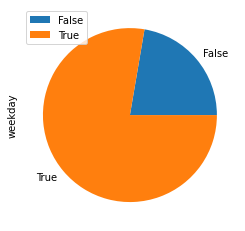

In [ ]:
df_rndc[df_rndc['product'] == 'VARIOS CONTENEDOR VACIO'][['weekday','operation_code']].groupby('operation_code').count().plot.pie(y = 'weekday')